note: multilinear regression with 3 cameras to compare with KNN from Anne

In [1]:
#- main machine learning libraries used

# import tensorflow
import tensorflow as tf
import tensorflow.keras as keras  
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error



#- other libraries used
import itertools
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt 
from platform import python_version
from datetime import datetime as dt
import hydroeval as he # includes nash suchcliff efficiency (nse) goodness of fit similar to R^2
from pygam import LinearGAM, s, f  #  import a GAM that’s made for regression problems


In [2]:
python_version()

'3.9.12'

In [3]:
tf.__version__

'2.9.1'

In [4]:
home_dir = "/Users/ehsanmos/MLP_dataset/atmmodel_k_zero_old"

# with 3 cameras and 10pnts



# original atmmodel.csv
# plot_name_tag = 'april'
# atmmodel = "atmmodel_april_2016_k_zero.csv" # prediction with npts=10 

# # atmmodel = "atmmodel_april_2016_k_zero_npts_larger10.csv" # prediction with npts=10 



plot_name_tag = 'july'
atmmodel = "atmmodel_july_2016_k_zero.csv"




# with 9 cameras
# atmmodel = "atmmodel_july_2016_k_zero_9cams4bands.csv"

atmmodel_fp = os.path.join(home_dir, atmmodel)

In [5]:
plot_output_dir = home_dir

In [6]:
print(atmmodel_fp)

if (not os.path.isfile(atmmodel_fp)):
    raise SystemExit()
else:
    print("input dataset found!")

/Users/ehsanmos/MLP_dataset/atmmodel_k_zero_old/atmmodel_july_2016_k_zero.csv
input dataset found!


In [7]:
# read data

training_ds = pd.read_csv(atmmodel_fp, engine='python')

print(training_ds.shape)
print(training_ds.columns)

(21181, 15)
Index(['path', 'orbit', 'block', 'line', 'sample', 'lat', 'lon', 'an', 'ca',
       'cf', 'rms', 'weight', 'npts', 'cloud', 'var'],
      dtype='object')


### drop unnecesary columns and build dataset with 9 cameras

In [8]:
# excluce_columns = ['path', 'orbit', 'img_block', 'line', 'sample', 'firstLat', 'firstLon', 'weight', 'npts', 'cloud', 'var']

# excluce_columns = ['path', 'orbit', 'block', 'line', 'sample', 'lat', 'lon', 'weight', 'npts', 'cloud', 'var']

excluce_columns = ['path', 'orbit', 'block', 'line', 'sample', 'weight', 'npts', 'cloud', 'var']

training_ds = training_ds.drop(excluce_columns, axis=1)

In [9]:
print('we are using %s columns in our training dataset:' %len(training_ds.columns))
print(training_ds)  # columns should be only 9 cameras + rms 

we are using 6 columns in our training dataset:
             lat         lon        an        ca        cf        rms
0      74.129692  199.405884  0.262749  0.437330  0.407132  10.210000
1      74.129883  199.405034  0.230663  0.433960  0.353881  12.070000
2      74.131416  199.398232  0.183614  0.391629  0.296317   6.852500
3      74.132183  199.394831  0.258165  0.448654  0.353881   8.960000
4      74.132952  199.391434  0.258974  0.432746  0.369924   7.921111
...          ...         ...       ...       ...       ...        ...
21176  76.458504  212.885146  0.171860  0.617289  0.373036   6.430000
21177  76.458772  212.885619  0.183526  0.620280  0.389937   6.350000
21178  76.459308  212.886570  0.182330  0.623421  0.375279   7.690000
21179  76.473239  212.911314  0.149573  0.658421  0.369296   8.485000
21180  76.473774  212.912273  0.168569  0.658122  0.390536   8.132500

[21181 rows x 6 columns]


In [10]:
# # rename column names
# train_dataset.rename(columns={' an':'an', ' ca':'ca', ' cf':'cf', ' rms':'rms'}, inplace=True)
# print(train_dataset.columns)
# print(type(train_dataset))

## >>> cleaning dataset >>>

In [11]:
training_ds.max()

lat     79.073534
lon    220.001111
an       1.413194
ca       1.323347
cf       2.314382
rms    119.250000
dtype: float64

## remove negative values

- we want to train our models, so we will remove negative values, NAN values, masked values such as land mask, etc. 

In [12]:
print('before dropping negative values: (%s, %s)' %training_ds.shape)

#- remove/ drop negative values from all input features

training_ds.drop((training_ds[training_ds['an'] < 0.0].index) | 
                (training_ds[training_ds['ca'] < 0.0].index) | 
                (training_ds[training_ds['cf'] < 0.0].index), inplace=True)



#- remove/ drop negative values from all input features

# training_ds.drop((training_ds[training_ds['da'] < 0.0].index) | 
#                 (training_ds[training_ds['ca'] < 0.0].index) | 
#                 (training_ds[training_ds['ba'] < 0.0].index) |
#                 (training_ds[training_ds['aa'] < 0.0].index) |
#                 (training_ds[training_ds['anr'] < 0.0].index) |
#                 (training_ds[training_ds['af'] < 0.0].index) |
#                 (training_ds[training_ds['bf'] < 0.0].index) |
#                 (training_ds[training_ds['cf'] < 0.0].index) |
#                 (training_ds[training_ds['df'] < 0.0].index), inplace=True)


print('after dropping negative values: (%s, %s)' %training_ds.shape)

before dropping negative values: (21181, 6)
after dropping negative values: (21181, 6)


/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_17107/117202112.py:5: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  training_ds.drop((training_ds[training_ds['an'] < 0.0].index) |


## >>> outlier detection and removal >>>

### Removing reflectance values as outliers in all cameras

In [13]:
cam_outlier = 1


training_ds.drop(training_ds[(training_ds['ca'] > cam_outlier) |
                           (training_ds['an'] > cam_outlier) |
                           (training_ds['cf'] > cam_outlier)].index, inplace=True)



# training_ds.drop(training_ds[(training_ds['da'] > cam_outlier) |
#                            (training_ds['ca'] > cam_outlier) |
#                            (training_ds['ba'] > cam_outlier) |
#                            (training_ds['aa'] > cam_outlier) |
#                            (training_ds['anr'] > cam_outlier) |
#                            (training_ds['af'] > cam_outlier) |
#                            (training_ds['bf'] > cam_outlier) |
#                            (training_ds['cf'] > cam_outlier) |
#                            (training_ds['df'] > cam_outlier)].index, inplace=True)

### Method 1: removing roughness values > 200 cm

In [14]:
# training_ds.drop((training_ds[training_ds['rms'] > 30].index), inplace=True)

### Method 2: removing roughness values with Interquartile Range Method (IQR)

- Method: find 25 and 75 percentiles in data, calculate inter-quartile range (IQR), set the cut off threshold, and remove outliers from data

In [15]:
#- identify outliers in roughnes valueswith interquartile range (IQRange)

def rms_outlier_removal(dataset_df: pd.DataFrame) -> pd.DataFrame:
    
    from numpy import percentile

    def remove_outliers_IQR(df, cutoff):
        df.drop((df[df['rms'] > cutoff].index), inplace=True)
        print('Removing outliers (IQR method): after dropping roughness values > %.1f in dataset; new shape= (%s,%s)' %(cutoff, df.shape[0], df.shape[1]))
        return 0 # because inplace=True

    #- extract data 
#     data = dataset_df.loc[:,'rms']
    data = dataset_df.loc[:,'rms']  # mean_ATM_roughness == rms

    print(type(data))
    #- calculate InterQuartile Range == IQR
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th= %.3f (cm), 75th= %.3f (cm), InterQuartile Range= %.3f (cm)' % (q25, q75, iqr))
    #- calculate the outlier cutoff
    cut_off = iqr * 3
    lower, upper = q25 - cut_off, q75 + cut_off
    print('lower cutoff= %.1f, upper cutoff= %.1f' % (lower, upper))
    #- identify outliers
    outliers = [x for x in data if x > upper] # list comprehension method
    print('Identified outliers: %d \n' % len(outliers))
    #- remove outliers
    remove_outliers_IQR(dataset_df, upper)
    
    return dataset_df


In [16]:
training_ds = rms_outlier_removal(training_ds)

<class 'pandas.core.series.Series'>
Percentiles: 25th= 4.298 (cm), 75th= 10.054 (cm), InterQuartile Range= 5.756 (cm)
lower cutoff= -13.0, upper cutoff= 27.3
Identified outliers: 379 

Removing outliers (IQR method): after dropping roughness values > 27.3 in dataset; new shape= (13557,6)


In [17]:
# def check_nan_in_DF(training_ds: pd.DataFrame):
    
#     if (training_ds['da'].isnull().values.any() | 
#         training_ds['ca'].isnull().values.any() | 
#         training_ds['ba'].isnull().values.any() |
#         training_ds['aa'].isnull().values.any() |
#         training_ds['anr'].isnull().values.any() |
#         training_ds['af'].isnull().values.any() |
#         training_ds['bf'].isnull().values.any() |
#         training_ds['cf'].isnull().values.any() |
#         training_ds['df'].isnull().values.any()):

#         print('found NAN in one DF column... removing NAN')
#         training_ds.dropna(axis=0, inplace=True)
#     else:
#         print('did not find NAN in dataset') 



def check_nan_in_DF(training_ds: pd.DataFrame):
    
    if (
        training_ds['ca'].isnull().values.any() | 
        training_ds['an'].isnull().values.any() |
        training_ds['cf'].isnull().values.any()):

        print('found NAN in one DF column... removing NAN')
        training_ds.dropna(axis=0, inplace=True)
    else:
        print('did not find NAN in dataset') 

In [18]:
check_nan_in_DF(training_ds)

did not find NAN in dataset


In [19]:
#~ double check for any negative values in all columns
if ((training_ds.values < 0).any()):
    print('found some negative values in DF! something is wrong!')
else:
    print('double check: did not find any negative value in DF!')

double check: did not find any negative value in DF!


In [20]:
## check values after cleaning dataset
training_ds.max()

lat     79.073006
lon    220.001111
an       0.849482
ca       0.988107
cf       0.999887
rms     27.310000
dtype: float64

In [21]:
training_ds

,lat,lon,an,ca,cf,rms
0,74.129692,199.405884,0.262749,0.437330,0.407132,10.210000
1,74.129883,199.405034,0.230663,0.433960,0.353881,12.070000
2,74.131416,199.398232,0.183614,0.391629,0.296317,6.852500
3,74.132183,199.394831,0.258165,0.448654,0.353881,8.960000
4,74.132952,199.391434,0.258974,0.432746,0.369924,7.921111
...,...,...,...,...,...,...
21176,76.458504,212.885146,0.171860,0.617289,0.373036,6.430000
21177,76.458772,212.885619,0.183526,0.620280,0.389937,6.350000
21178,76.459308,212.886570,0.182330,0.623421,0.375279,7.690000
21179,76.473239,212.911314,0.149573,0.658421,0.369296,8.485000


In [22]:
# shuffle dataset

from sklearn.utils import shuffle

train_dataset = shuffle(training_ds)

In [23]:
#- split data set to X and Y

X = train_dataset.iloc[:, :-1] # to select up to last column of dataset OR [:, 0:3]
Y = train_dataset.iloc[:, -1:] # to select last column of DF

print(X.shape)
print(Y.shape)

(13557, 5)
(13557, 1)


In [24]:
# change to list? faster?
# XX = 
XX = X.values.tolist()
YY = Y.values.tolist()

In [25]:
#- now split dataset to train-test

from sklearn.model_selection import train_test_split

#- we use this function to split data-- from here because we are usiong SKlearn library, we change all data structures from Pandas DF to numpy
# X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, random_state=123) # Q- input is DF or numpy array?

testdata_size = 0.3
print("test size= %d percent" %(testdata_size*100))
x_train, x_test, y_train, y_test = train_test_split(XX, YY, test_size=testdata_size, random_state=123) # Q- input is DF or numpy array?

print("train:")
print(len(x_train))
print(len(y_train))

print("\ntest:")
print(len(x_test))
print(len(y_test))


test size= 30 percent
train:
9489
9489

test:
4068
4068


In [26]:
# x_train

## >>> Simple Linear Regression >>>

train simple LR with 2 parameters to estimate

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create linear regression object 
lr_model = LinearRegression() # create an estimator obj
lr_model.get_params()

# Fit alg. to training dataset/Train the model using the training sets- here we use X_train(3 features)
lr_model.fit(x_train, y_train) # fit(X,y) will fit data to our algortihm and makes it learn from data == training step

lr_train_score = lr_model.score(x_train, y_train)
print("R^2 train (score): %.2f" %lr_train_score)

y_train_pred_lr = lr_model.predict(x_train)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_pred_lr))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_pred_lr))

# NSE-traing
# nse_lr = he.evaluator(he.nse, y_train, y_train_pred_lr)  # order(prediction,target)
# print('NSE train: %.2f' %nse_lr)
# # print(lr_model.coef_)


R^2 train (score): 0.06
RMSE train: 4.96
MAE train: 3.70


3 Best metrics to evaluate Regression Model:
- R^2: shows how well the model can fit training data/variables
- RMSE: is a measure of prediction error; it gives larger penalization to big prediction error by square it
- MAE: it treats all errors the same

Model evaluation helps you to understand the performance of your model and makes it easy to present your model to other people.
source: https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

In [28]:
# # calculate R-squared of regression model
# r_squared = mlr_model.score(X, Y)
# print('R^2 training: %s' %round(r_squared, 2))

R^2 test: 0.06
RMSE test: 4.80
MAE test: 3.64
NSE: 0.06


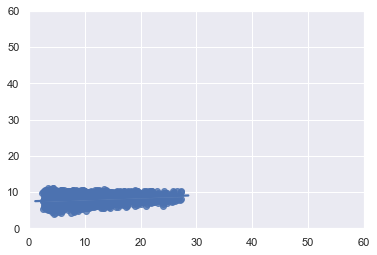

In [29]:
# Predict using the linear model- on specific block data- on transect data
# x_test = 'open 3 MISR cameras that create transect block, create x_test dataset from 3 cameras (an, ca, cf), and then make prediction '
y_pred_lr = lr_model.predict(x_test)


######## plot 
import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()

sns.regplot(x=y_test, y=y_pred_lr, truncate=False, ax=ax)#, color='g')

ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'simpleLinearReg_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))



r2_model = r2_score(y_test, y_pred_lr)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_lr))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_lr))

# NSE
nse_lr = he.evaluator(he.nse, y_pred_lr, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_lr)


## >>> Polynomial linear regression >>>

Although this model allows for a nonlinear relationship between Y and X, polynomial regression is still considered linear regression since it is linear in the regression coefficients. it means relations of Y with respect to X is linear == degree of equation (power of X) is 1 so the relationship has power of 1

R^2 train: 0.11
RMSE train: 4.82
MAE train: 3.58
R^2 test: 0.09
RMSE test: 4.72
MAE test: 3.55
NSE: 0.09


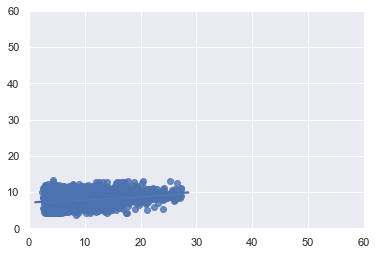

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math

poly_feature_matrix = PolynomialFeatures(degree=2) # how nuber of features change?
x_train_poly = poly_feature_matrix.fit_transform(x_train)

# print(x_train.shape)
# print(x_train_poly.shape) # Q- why degree= 3, 3 features turned to 20 features?

poly_linear_reg_model = LinearRegression() # build an instance of the model
# print(poly_linear_reg_model)

poly_linear_reg_model.fit(x_train_poly, y_train) # Then we fit the qlgorithm to our data/train the model
# training model score
ploy_train_score = poly_linear_reg_model.score(x_train_poly, y_train)
print("R^2 train: %.2f" %ploy_train_score)

y_train_poly = poly_linear_reg_model.predict(x_train_poly)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_poly))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_poly))

# metrics
# nse_lr = he.evaluator(he.nse, y_train, y_train_poly)  # order(prediction,target)
# print('NSE train: %.2f' %nse_lr)

# predict
x_test_poly = poly_feature_matrix.fit_transform(x_test)
y_pred_plr = poly_linear_reg_model.predict(x_test_poly) # prediction (Y^)

##### R^2 score
r2_plr = r2_score(y_test, y_pred_plr)
print('R^2 test: %s' %round(r2_plr,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_plr))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_plr))


# NSE
nse_plr = he.evaluator(he.nse, y_pred_plr, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_plr) # shows gof==how model fits data


# print(len(y_test))
# print(len(y_pred_plr))

################################# plot data
# plt.figure(figsize=(10, 6))
# plt.title("poly regression", size=16)
# plt.scatter(y_test, y_pred_plr)
# plt.plot(y_test, y_pred_plr, c="red")
# plt.show()


import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_plr, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'polyLinearReg_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))

## >>> K-nearest neighbor >>>

In [31]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(x_train, y_train) # fit algorithm to data and train it

# training score
knn_train_score = knn_model.score(x_train, y_train)
print("R^2 train: %.2f" %knn_train_score)

y_train_pred_knn = knn_model.predict(x_train)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_pred_knn))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_pred_knn))

R^2 train: 0.58
RMSE train: 3.31
MAE train: 2.23


In [32]:
# performance metrics on train dataset == algorithm is fit to it





R^2 test: 0.32
RMSE test: 4.06
MAE test: 2.75
NSE: 0.32


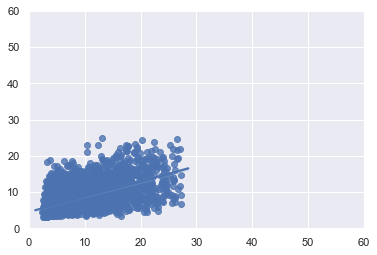

In [33]:
# performance metrics on test dataset

# Predict on dataset which model has not seen before
y_pred_knn = knn_model.predict(x_test)

# report evaluation of mdoel performace on test data
r2_model = r2_score(y_test, y_pred_knn)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_knn))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_knn))



### NSE
nse_knn = he.evaluator(he.nse, y_pred_knn, y_test)  # order(prediction,target)
print('NSE: %.2f' %nse_knn)




import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_knn, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'knn_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))


In [34]:
# change list to np.array 

y_test = np.array(y_test) 
print(type(y_test))
print(type(y_pred_knn))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### plot histogram for test dataset

In [35]:
def plot_histogram(obs_ds: np.array, model_ds: np.array):
    # this function plots histogram of obs vs. modeled data
    # todo: move label as arg 
    
    def save_plot(plot_output_dir: str, plot_name: str):
        plot_fp = os.path.join(plot_output_dir, plot_name)
        print(plot_fp)
        plt.savefig(plot_fp)
    
    bin_size = 20
    plt.hist(obs_ds, density=True, bins=bin_size, label='ATM-derived', color='blue', alpha=0.5)  # density=False would make counts
    plt.hist(model_ds, density=True, bins=bin_size, label='MISR-derived', color='orange', alpha=0.5)  # density=False would make counts
    plt.xlim(0,50)
#     plt.ylim(0,0.25)

    plt.xlabel('Roughness', fontsize = 11)
    plt.ylabel('Frequency', fontsize = 11)
    plt.legend(loc="upper right")
    # plt.title("ATM vs. MISR for %s" %sim_month_hist_label)

    plt.rc('legend', fontsize=11)    # legend fontsize

    
    # if we want to save figure, set path and name
    plot_name = 'histogram_'+plot_name_tag
    
    save_plot(plot_output_dir, plot_name)
    


    return 0


/Users/ehsanmos/MLP_dataset/atmmodel_k_zero_old/histogram_july


0

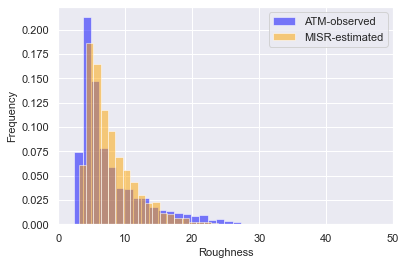

In [36]:
plot_histogram(obs_ds=y_test, model_ds=y_pred_knn)

In [37]:
print(len(x_train))
print(len(y_train))

print(type(x_train))
print(type(y_train))

9489
9489
<class 'list'>
<class 'list'>


In [38]:
# x_train = np.array(x_train)
# y_train = np.array(y_train)

# print(type(x_train))
# print(type(y_train))

In [39]:
# plot_histogram(obs_ds=x_train, model_ds=y_train)

### Q-Q plots for test dataset

In [40]:
def qq_plot(y_actual: np.array, y_predicted: np.array):
    print(y_actual.shape)
    print(y_predicted.shape)
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt


    residuals = y_actual - y_predicted
    print(type(residuals))
    print(residuals.shape)


    plt.figure(figsize=(7,7))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot")
    
    return 0

In [41]:
# qq_plot(y_actual= y_test, y_predicted= y_pred_knn)

In [42]:
# import statsmodels.api as sm
# import matplotlib.pyplot as plt

# residuals = y_test - y_pred_knn
# # residuals = y_pred_knn


# #create Q-Q plot with 45-degree line added to plot
# fig = sm.qqplot(residuals, line='45')
# plt.show()

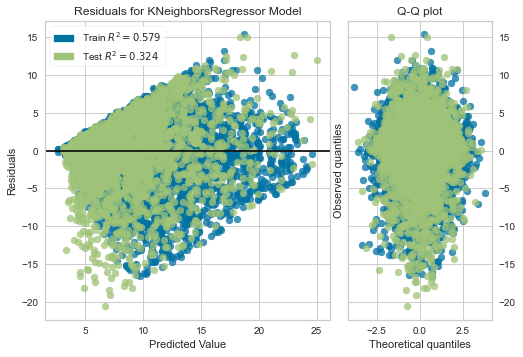

<AxesSubplot:title={'center':'Residuals for KNeighborsRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(knn_model, hist=False, qqplot=True)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


## >>> predicting transect block with my KNN >>>

In [44]:
# # order of cameras in training set
# x_train[0:5]

In [45]:
# # x_predict_3cams = 'build this df from 3 cameras of the image block'
# # home of 3 toa-refl 
# toa_refl_dir = '/Users/ehsanmos/MLP_dataset/transect_test_p79_b32'

# # 3 toa-refl for transect- later we can use masked-toa-refl because we are using a new logic in the next box to include negative pixels
# an = 'toa_refl_P079_O086932_B032_an_red.dat'
# cf = 'toa_refl_P079_O086932_B032_cf_red.dat'
# ca = 'toa_refl_P079_O086932_B032_ca_red.dat'


# # open and read each file
# an_arr = np.fromfile(os.path.join(toa_refl_dir, an), dtype=np.double)[0:1048576].reshape((512,2048))
# cf_arr = np.fromfile(os.path.join(toa_refl_dir, cf), dtype=np.double)[0:1048576].reshape((512,2048))
# ca_arr = np.fromfile(os.path.join(toa_refl_dir, ca), dtype=np.double)[0:1048576].reshape((512,2048))


In [46]:
# print(type(an_arr))
# print(an_arr.shape)

note: have negative (-1) pixels in toa-refl image; it represents the black area around the image block?



Q- first build X-train Test samples dataset and then predict?-> not doable

Q- why warning in prediction?-> changed training DS to list and resolved

Q- why prediction for a single block is so slow? -> warning removed, a bit faster

Q- how make a dataset from block first before prediction?

In [47]:
# # this prediction here only runs with 3 features/cams. if later we want to add lat/lon as feature, we need to include lat/lon for predcited transect too
# rough_predicted_arr = []

# for row in range(512):
#     for col in range(2048):
#         # check if a pixel in an is negative
#         if (an_arr[row,col] < 0):
#             rough_predicted_arr.append(an_arr[row,col]) # if negative, append to predicted array
#             continue
            
#         if (cf_arr[row,col] < 0):
#             rough_predicted_arr.append(cf_arr[row,col])
#             continue
            
#         if (ca_arr[row,col] < 0):
#             rough_predicted_arr.append(ca_arr[row,col])
#             continue
            
#         # make prediction for each single pixel
#         y_pred_for_pixel_knn = knn_model.predict([[an_arr[row,col], ca_arr[row,col], cf_arr[row,col]]]) # order based on training ds
# #         print(y_pred_for_pixel_knn[0][0])
#         rough_predicted_arr.append(y_pred_for_pixel_knn[0][0])

   

In [48]:
# print(type(rough_predicted_arr))
# print(len(rough_predicted_arr))

In [49]:
# pred = rough_predicted_arr[1000]
# print(pred)
# print(type(pred))

In [50]:
# # change to np.array?
# block_arr_p79_b32 = np.array(rough_predicted_arr).reshape(512,2048)
# print(type(block_arr_p79_b32))
# print(block_arr_p79_b32.shape)

In [51]:
# print(block_arr_p79_b32[0,1000])

In [52]:
# # this function plots rouhgness array
# def plot_here_and_write(in_arr, img_dir):
#     write_mode = 0
# #     img_label = 'path_'+path_num+'_'+'blocks_'+str(start_block)+'_'+str(end_block)+'_cam_'+cam
#     img_format = ".jpg"
#     %matplotlib inline 

#     plt.gray() # This will show the images in grayscale as default

#     plt.figure(figsize=(30,30))  # set the figure size

#     plt.imshow(in_arr)
#     plt.show()
    
#     if (write_mode):
#         print('save mode: on, we write images to disc')
        
#         out_img = img_label+img_format
#         out_img_fullpath = os.path.join(img_dir, out_img)
#         print("-> output img is: %s" %out_img_fullpath)
#         pltimg.imsave(out_img_fullpath, in_arr)
#         #     plt.savefig(out_img)
    
#     return 0

In [53]:
# plot_here_and_write(block_arr_p79_b32, out_dir)

In [54]:
# # Write array to a file as a binary to plot the roughness on transect and compare modeled/predicted roughnesss with measured/observed ATM across transect

# # set path
# out_dir = '/Users/ehsanmos/MLP_dataset/transect_test_p79_b32'
# out_bin = 'block_arr_p79_b32.dat'

# # write array as binary
# block_arr_p79_b32.tofile(os.path.join(out_dir, out_bin)) 




## >>> Generalized additive models (GAM) for regression >>>

In [55]:
gam = LinearGAM(s(0) + s(1) + s(2)).fit(x_train, y_train)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.9802
Link Function:                     IdentityLink Log Likelihood:                                -38546.0136
Number of Samples:                         9489 AIC:                                            77185.9876
                                                AICc:                                           77186.4651
                                                GCV:                                               22.8752
                                                Scale:                                             22.6758
                                                Pseudo R-Squared:                                   0.1347
Feature Function                  Lam

/opt/anaconda3/lib/python3.9/site-packages/pygam/pygam.py:593: RuntimeWarning: invalid value encountered in reciprocal
  weights ** -1)**-0.5)
/opt/anaconda3/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values
/opt/anaconda3/lib/python3.9/site-packages/pygam/distributions.py:86: RuntimeWarning: invalid value encountered in reciprocal
  return (np.sum(weights * self.V(mu)**-1 * (y - mu)**2) /
/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_17107/1277045253.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [56]:
list(gam.statistics_.keys())

['n_samples',
 'm_features',
 'edof_per_coef',
 'edof',
 'scale',
 'cov',
 'se',
 'AIC',
 'AICc',
 'pseudo_r2',
 'GCV',
 'UBRE',
 'loglikelihood',
 'deviance',
 'p_values']

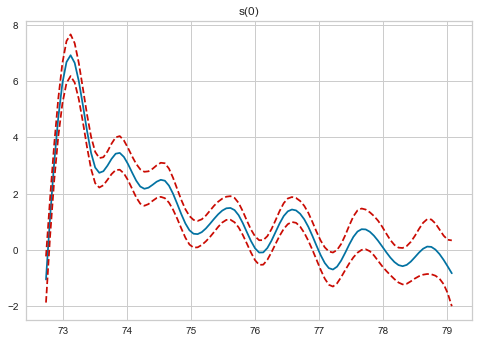

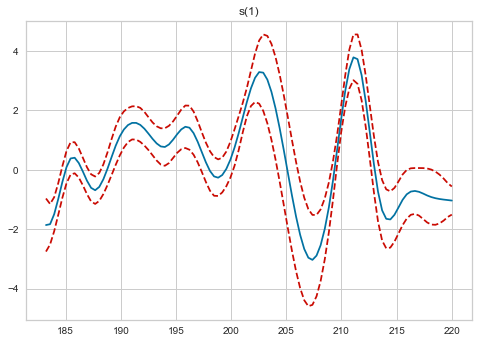

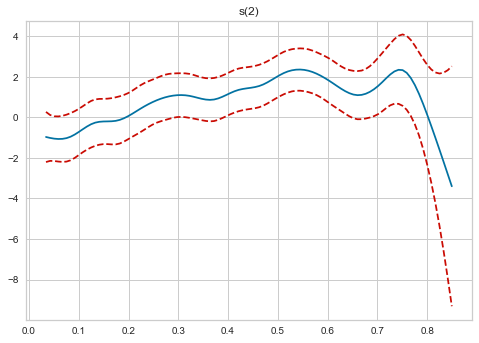

In [57]:
import matplotlib.pyplot as plt

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [58]:
# x_predict_3cams

In [59]:
x_predict_3cams_df = pd.DataFrame(x_predict_3cams, ?????)

SyntaxError: invalid syntax (3824813711.py, line 1)

In [ ]:
# Predict on dataset which model has not seen before
y_pred_transect_knn = knn_model.predict(x_predict_3cams)


# change y_pred_transect_knn --> 2D array and run test






In [ ]:
# visualize the predicted image
# plot the transect



In [ ]:
# extract data along transect and plot R^2 fro transect

